In [122]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import decomposition

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [123]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [124]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [125]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [126]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
    
    # 개별 스텝간 공정 소요시간(초) 변수를 생성합니다. 
    # ex. gen_tmdiff_0406 : 04 스텝 공정 완료 시간과 06 스텝 공정 완료 시간의 차이 
    
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()

    return df

# 4. 데이터 전처리

In [127]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()
del train

In [128]:
# -----------------------------------
# 3 장 EDA 분석에 필요한 변수를 선언합니다.
# -----------------------------------

# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [129]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']
df_train = gen_duration_feats(df_train, lst_stepsgap)
df_predict = gen_duration_feats(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,1912.0,146.0,846.0,16.0,477.0,16.0,411.0
1,1911.0,145.0,847.0,16.0,476.0,16.0,411.0


# Cyclic Transformation 적용

In [130]:
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)

In [131]:
endtime_col = df_train.filter(regex='end_time$').columns.tolist()
cyclic_transformation(df_train, endtime_col)
cyclic_transformation(df_predict, endtime_col)

In [106]:
df_train.head(1)

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para

In [55]:
df_predict.head(1)

,module_name,key_val,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_p

# Category 변수 처리

In [132]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
# eq2idx = {}
# for i, eq in enumerate(df_train['module_name_eq'].unique()):
#     eq2idx[eq] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)
# eq cat 화
# col2cat(df_train, 'module_name_eq', eq2idx)
# col2cat(df_predict, 'module_name_eq', eq2idx)

0       0
1       0
2       0
3       0
4       0
       ..
257    45
258    46
259    46
260    46
261    46
Name: module_name, Length: 262, dtype: category
Categories (47, int64): [0, 1, 2, 3, ..., 43, 44, 45, 46]

In [133]:
# num feature 정의(y 제외하고 해야함.)
cat_features = ['module_name']
num_features = list(df_train.columns[df_train.dtypes==float])
# datetime_features = list(df_train.columns[df_train.dtypes==np.int64])
num_features.remove('y')

col_numerical = num_features + df_train.filter(regex='^gen_').columns.tolist()

In [134]:
# threshold 인자를 변경하여 분산의 기준값을 수동으로 선택할 수 있습니다.
thresholder = VarianceThreshold(threshold=0)
_ = thresholder.fit_transform(df_train[col_numerical])

 # 분산이 0이면 True 이므로 제거할 컬럼을 추출합니다.  
mask = ~thresholder.get_support()
cols_var_drop = np.asarray(col_numerical)[mask].tolist()
print(f'** {len(cols_var_drop)} Features to Drop by Low Variance')
print(f'{cols_var_drop}')

** 79 Features to Drop by Low Variance
['04_epd_para4', '04_epd_para40', '04_epd_para63', '04_epd_para80', '04_he_para1', '04_power_para14', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para24', '04_time_para5', '06_epd_para80', '06_he_para1', '06_hv_para3', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para14', '06_power_para68', '06_power_para82', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_epd_para40', '12_epd_para63', '12_epd_para80', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para68', '12_temp_para54', '13_epd_para4', '13_epd_para40', '13_epd_para63', '13_epd_para80', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para68', '13_temp_para54', '17_epd_para4', '17_epd_para40', '17_epd_para63', '17_epd_para80', '17_he_para1', '17_he_para95', '17_power_para49', '17_power_para68', '17_temp_para54', '18_epd_para4', '18_epd_para40', '18_epd_para63', '18_epd_para80', '18_he_para1', '18_he_para95', '18_power_para49', '

In [135]:
df_train.drop(cols_var_drop,axis=1, inplace=True)
df_predict.drop(cols_var_drop,axis=1, inplace=True)

# 모델링 진행

In [136]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [137]:
def prep_cate_feats(df_tr, df_te, feat_nm):

    df_merge = pd.concat([df_tr, df_te])

    # 컬럼명과 범주형 변수의 레벨명을 이용한 새로운 컬럼명을 자동생성합니다. 
    # ex. module_name_eq -> module_name_eq_EQ01, module_name_eq_EQ02, etc.
    df_merge = pd.get_dummies(df_merge, columns=[feat_nm])

    df_tr = df_merge.iloc[:df_tr.shape[0], :].reset_index(drop=True)
    df_te = df_merge.iloc[df_tr.shape[0]:, :].reset_index(drop=True)

    return df_tr, df_te

# module_name_eq 의 원-핫 인코딩 변수를 생성합니다.
# df_train, df_predict = prep_cate_feats(df_train, df_predict, 'module_name_eq')
df_final, df_predict_final = prep_cate_feats(df_final, df_predict_final, 'module_name')

In [138]:
num_features = list(df_final.columns[df_final.dtypes==float])
# datetime_features = list(df_final.columns[df_final.dtypes==np.int64])
module_col = df_final.filter(regex='module_name').columns.tolist()
num_features.remove('y')

COLS = num_features+module_col

In [139]:
df_final[COLS]

,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para22,06_he_para88,06_he_para95,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para10,13_gas_para13,13_gas_para15,13_gas_para19,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para33,13_gas_para36,13_gas_para39,13_gas_para46,13_gas_para48,13_gas_para50,13_

# 모델링

In [140]:
from catboost import CatBoostRegressor
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

In [161]:
E = df_final[df_final['gen_tmdiff']<=1870]
L = df_final[df_final['gen_tmdiff']>1870]
E_predict = df_predict_final[df_predict_final['gen_tmdiff']<=1870]
L_predict = df_predict_final[df_predict_final['gen_tmdiff']>1870]

In [141]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred, squared=False), 4)

In [162]:
def objective(trial):
    params_xgb = {
        'optimizer':trial.suggest_categorical('optimizer',['gbtree','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3,1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 4, 12),
        'random_state': trial.suggest_categorical('random_state', [0]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_methold':'gpu_hist',
        'gpu_id':'0'
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(E[COLS], np.log1p(E['y']), test_size=0.15, shuffle=True, random_state=71)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmse_val = rmse(y_valid, xgb_pred)
    
    return rmse_val

In [163]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-09 23:45:42,085] A new study created in memory with name: xgb_parameter_opt


[23:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:42,883] Trial 0 finished with value: 6.6423 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7319939418114051, 'colsample_bytree': 0, 'subsample': 0.7190609389379257, 'learning_rate': 0.018410729205738687, 'n_estimators': 1644, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 260}. Best is trial 0 with value: 6.6423.


[23:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:43,303] Trial 1 finished with value: 0.0041 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.020584494295802447, 'colsample_bytree': 0, 'subsample': 0.978936896513396, 'learning_rate': 0.2595942550311264, 'n_estimators': 2202, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 56}. Best is trial 1 with value: 0.0041.
[I 2022-07-09 23:45:43,551] Trial 2 finished with value: 6.6423 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.43194501864211576, 'colsample_bytree': 0, 'subsample': 0.5038603981386294, 'learning_rate': 0.10952662748632554, 'n_estimators': 1481, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 110}. Best is trial 1 with value: 0.0041.


[23:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:44,182] Trial 3 finished with value: 0.0041 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.19967378215835974, 'colsample_bytree': 0, 'subsample': 0.6599641068895281, 'learning_rate': 0.10150667045928574, 'n_estimators': 559, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 52}. Best is trial 1 with value: 0.0041.


[23:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:44,432] Trial 4 finished with value: 6.6423 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.9656320330745594, 'colsample_bytree': 0, 'subsample': 0.8658781436815228, 'learning_rate': 0.032925293631105246, 'n_estimators': 1067, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 133}. Best is trial 1 with value: 0.0041.
[I 2022-07-09 23:45:44,658] Trial 5 finished with value: 6.6423 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.034388521115218396, 'colsample_bytree': 0, 'subsample': 0.9365242814551473, 'learning_rate': 0.02752069685079053, 'n_estimators': 6659, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 157}. Best is trial 1 with value: 0.0041.


[23:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:44,890] Trial 6 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.9695846277645586, 'colsample_bytree': 0, 'subsample': 0.8425929763527802, 'learning_rate': 0.3946212980759094, 'n_estimators': 8959, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 277}. Best is trial 1 with value: 0.0041.


[23:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:45,122] Trial 7 finished with value: 6.6423 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.045227288910538066, 'colsample_bytree': 0, 'subsample': 0.527731231534285, 'learning_rate': 0.04574578205475402, 'n_estimators': 2786, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 108}. Best is trial 1 with value: 0.0041.


[23:45:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:48,157] Trial 8 finished with value: 0.0041 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.14092422497476265, 'colsample_bytree': 0, 'subsample': 0.8615378865278278, 'learning_rate': 0.01338626158454391, 'n_estimators': 9871, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 60}. Best is trial 1 with value: 0.0041.


[23:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:48,576] Trial 9 finished with value: 0.0041 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7068573438476171, 'colsample_bytree': 0, 'subsample': 0.810305017628691, 'learning_rate': 0.20434554984161393, 'n_estimators': 833, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 35}. Best is trial 1 with value: 0.0041.


[23:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:48,824] Trial 10 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3637276736216312, 'colsample_bytree': 0, 'subsample': 0.3052831235214052, 'learning_rate': 0.41534235816464743, 'n_estimators': 4280, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 197}. Best is trial 1 with value: 0.0041.


[23:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:49,745] Trial 11 finished with value: 0.0037 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.26120125603452177, 'colsample_bytree': 0, 'subsample': 0.9928645659901887, 'learning_rate': 0.11976079885579768, 'n_estimators': 3625, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 15}. Best is trial 11 with value: 0.0037.


[23:45:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:50,180] Trial 12 finished with value: 0.0041 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.2400665831386536, 'colsample_bytree': 0, 'subsample': 0.9965656351535926, 'learning_rate': 0.19854019827517552, 'n_estimators': 4085, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 21}. Best is trial 11 with value: 0.0037.


[23:45:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:51,003] Trial 13 finished with value: 0.0031 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.26318110203021444, 'colsample_bytree': 0, 'subsample': 0.9698813014048833, 'learning_rate': 0.1983819185292645, 'n_estimators': 5576, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}. Best is trial 13 with value: 0.0031.


[23:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:51,695] Trial 14 finished with value: 0.0039 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.5643579606664657, 'colsample_bytree': 0, 'subsample': 0.732973667441923, 'learning_rate': 0.08782926998454499, 'n_estimators': 6230, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 15}. Best is trial 13 with value: 0.0031.


[23:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:52,679] Trial 15 finished with value: 0.0035 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.33091284180681496, 'colsample_bytree': 0, 'subsample': 0.9122407019367289, 'learning_rate': 0.06097040966413527, 'n_estimators': 6193, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 7}. Best is trial 13 with value: 0.0031.
[I 2022-07-09 23:45:52,929] Trial 16 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.549585533112228, 'colsample_bytree': 0, 'subsample': 0.524595125033872, 'learning_rate': 0.052852280851053264, 'n_estimators': 6090, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 86}. Best is trial 13 with value: 0.0031.


[23:45:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:53,207] Trial 17 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3316140814053474, 'colsample_bytree': 0, 'subsample': 0.9128355935376671, 'learning_rate': 0.14979872358931456, 'n_estimators': 7611, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 192}. Best is trial 13 with value: 0.0031.


[23:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:54,179] Trial 18 finished with value: 0.003 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.447704291130379, 'colsample_bytree': 0, 'subsample': 0.7696385327446578, 'learning_rate': 0.053644446665536895, 'n_estimators': 5043, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}. Best is trial 18 with value: 0.003.
[I 2022-07-09 23:45:54,428] Trial 19 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.6240887841439187, 'colsample_bytree': 0, 'subsample': 0.763028160825971, 'learning_rate': 0.036994033320942074, 'n_estimators': 5081, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 80}. Best is trial 18 with value: 0.003.


[23:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:54,682] Trial 20 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.4657346112658661, 'colsample_bytree': 0, 'subsample': 0.5984426662658658, 'learning_rate': 0.07505165323555044, 'n_estimators': 7541, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 167}. Best is trial 18 with value: 0.003.


[23:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:55,676] Trial 21 finished with value: 0.0033 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3259288841222604, 'colsample_bytree': 0, 'subsample': 0.8029246189419644, 'learning_rate': 0.060715955666671484, 'n_estimators': 5360, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 3}. Best is trial 18 with value: 0.003.


[23:45:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:57,692] Trial 22 finished with value: 0.0035 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.41022042258930985, 'colsample_bytree': 0, 'subsample': 0.7875315343664582, 'learning_rate': 0.02297124583247297, 'n_estimators': 4926, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 5}. Best is trial 18 with value: 0.003.


[23:45:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:58,723] Trial 23 finished with value: 0.0041 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.1472613596667962, 'colsample_bytree': 0, 'subsample': 0.6802349675455056, 'learning_rate': 0.04860384085106936, 'n_estimators': 5413, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 42}. Best is trial 18 with value: 0.003.


[23:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:45:58,987] Trial 24 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.2983801296649773, 'colsample_bytree': 0, 'subsample': 0.6148798269608104, 'learning_rate': 0.07207450651110678, 'n_estimators': 7390, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 80}. Best is trial 18 with value: 0.003.
[I 2022-07-09 23:45:59,258] Trial 25 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.4845998564748529, 'colsample_bytree': 0, 'subsample': 0.8212874984252829, 'learning_rate': 0.14772332841786906, 'n_estimators': 3454, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 236}. Best is trial 18 with value: 0.003.


[23:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:00,523] Trial 26 finished with value: 0.0039 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.15312757522568748, 'colsample_bytree': 0, 'subsample': 0.8943157423861848, 'learning_rate': 0.03762673521383742, 'n_estimators': 5443, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 37}. Best is trial 18 with value: 0.003.
[I 2022-07-09 23:46:00,786] Trial 27 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.6324999897386887, 'colsample_bytree': 0, 'subsample': 0.3695922525421673, 'learning_rate': 0.06644344277786056, 'n_estimators': 4494, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 67}. Best is trial 18 with value: 0.003.


[23:46:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:46:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:01,443] Trial 28 finished with value: 0.0036 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3880501473606351, 'colsample_bytree': 0, 'subsample': 0.7190747419444853, 'learning_rate': 0.29606814324069647, 'n_estimators': 8366, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 29}. Best is trial 18 with value: 0.003.
[I 2022-07-09 23:46:01,711] Trial 29 finished with value: 6.6423 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.5270496965332081, 'colsample_bytree': 0, 'subsample': 0.7746106770598338, 'learning_rate': 0.010367235436582677, 'n_estimators': 3141, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 106}. Best is trial 18 with value: 0.003.


[23:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer", "tree_methold" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Score: 0.003
Best trial: {'optimizer': 'gbtree', 'reg_lambda': 0.447704291130379, 'colsample_bytree': 0, 'subsample': 0.7696385327446578, 'learning_rate': 0.053644446665536895, 'n_estimators': 5043, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}


In [164]:
model_xgb = xgb.XGBRegressor(**study.best_params, tree_method='gpu_hist',gpu_id='0')
model_xgb.fit(E[COLS], np.log1p(E['y']))

[23:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, gamma=0, gpu_id='0',
             importance_type='gain', interaction_constraints='',
             learning_rate=0.053644446665536895, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=5043, n_jobs=12, num_parallel_tree=1,
             optimizer='gbtree', random_state=0, reg_alpha=0,
             reg_lambda=0.447704291130379, scale_pos_weight=1,
             subsample=0.7696385327446578, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

# L_XGB

In [165]:
def objective2(trial):
    params_xgb = {
        'optimizer':trial.suggest_categorical('optimizer',['gbtree','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3,1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 4, 12),
        'random_state': trial.suggest_categorical('random_state', [0]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_method':'gpu_hist',
        'gpu_id':'0'
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(L[COLS], np.log1p(L['y']), test_size=0.15, shuffle=True, random_state=71)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmse_val = rmse(y_valid, xgb_pred)
    
    return rmse_val

In [166]:
sampler = TPESampler(seed=42)
study2 = optuna.create_study(
    study_name="xgb_parameter_opt2",
    direction="minimize",
    sampler=sampler,
)
study2.optimize(objective2, n_trials=30)
print("Best Score:", study2.best_value)
print("Best trial:", study2.best_trial.params)

[I 2022-07-09 23:46:25,686] A new study created in memory with name: xgb_parameter_opt2


[23:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:28,001] Trial 0 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7319939418114051, 'colsample_bytree': 0, 'subsample': 0.7190609389379257, 'learning_rate': 0.018410729205738687, 'n_estimators': 1644, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 260}. Best is trial 0 with value: 0.0053.


[23:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:28,987] Trial 1 finished with value: 0.0047 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.020584494295802447, 'colsample_bytree': 0, 'subsample': 0.978936896513396, 'learning_rate': 0.2595942550311264, 'n_estimators': 2202, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 56}. Best is trial 1 with value: 0.0047.


[23:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:29,686] Trial 2 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.43194501864211576, 'colsample_bytree': 0, 'subsample': 0.5038603981386294, 'learning_rate': 0.10952662748632554, 'n_estimators': 1481, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 110}. Best is trial 1 with value: 0.0047.


[23:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:30,548] Trial 3 finished with value: 0.0049 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.19967378215835974, 'colsample_bytree': 0, 'subsample': 0.6599641068895281, 'learning_rate': 0.10150667045928574, 'n_estimators': 559, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 52}. Best is trial 1 with value: 0.0047.


[23:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:32,668] Trial 4 finished with value: 0.005 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.9656320330745594, 'colsample_bytree': 0, 'subsample': 0.8658781436815228, 'learning_rate': 0.032925293631105246, 'n_estimators': 1067, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 133}. Best is trial 1 with value: 0.0047.


[23:46:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:34,799] Trial 5 finished with value: 0.0051 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.034388521115218396, 'colsample_bytree': 0, 'subsample': 0.9365242814551473, 'learning_rate': 0.02752069685079053, 'n_estimators': 6659, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 157}. Best is trial 1 with value: 0.0047.


[23:46:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:35,243] Trial 6 finished with value: 0.0053 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.9695846277645586, 'colsample_bytree': 0, 'subsample': 0.8425929763527802, 'learning_rate': 0.3946212980759094, 'n_estimators': 8959, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 277}. Best is trial 1 with value: 0.0047.


[23:46:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:36,551] Trial 7 finished with value: 0.0052 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.045227288910538066, 'colsample_bytree': 0, 'subsample': 0.527731231534285, 'learning_rate': 0.04574578205475402, 'n_estimators': 2786, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 108}. Best is trial 1 with value: 0.0047.


[23:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:40,709] Trial 8 finished with value: 0.005 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.14092422497476265, 'colsample_bytree': 0, 'subsample': 0.8615378865278278, 'learning_rate': 0.01338626158454391, 'n_estimators': 9871, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 60}. Best is trial 1 with value: 0.0047.


[23:46:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:41,558] Trial 9 finished with value: 0.0049 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7068573438476171, 'colsample_bytree': 0, 'subsample': 0.810305017628691, 'learning_rate': 0.20434554984161393, 'n_estimators': 833, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 35}. Best is trial 1 with value: 0.0047.


[23:46:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:41,845] Trial 10 finished with value: 6.642 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3637276736216312, 'colsample_bytree': 0, 'subsample': 0.3052831235214052, 'learning_rate': 0.41534235816464743, 'n_estimators': 4280, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 197}. Best is trial 1 with value: 0.0047.


[23:46:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:42,896] Trial 11 finished with value: 0.0047 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.26120125603452177, 'colsample_bytree': 0, 'subsample': 0.9928645659901887, 'learning_rate': 0.11976079885579768, 'n_estimators': 3625, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 15}. Best is trial 1 with value: 0.0047.


[23:46:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:43,653] Trial 12 finished with value: 0.0047 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.2400665831386536, 'colsample_bytree': 0, 'subsample': 0.9965656351535926, 'learning_rate': 0.19854019827517552, 'n_estimators': 4085, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 21}. Best is trial 1 with value: 0.0047.


[23:46:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:44,722] Trial 13 finished with value: 0.005 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.26318110203021444, 'colsample_bytree': 0, 'subsample': 0.9698813014048833, 'learning_rate': 0.1983819185292645, 'n_estimators': 5576, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}. Best is trial 1 with value: 0.0047.


[23:46:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:45,807] Trial 14 finished with value: 0.0051 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.5627357553049621, 'colsample_bytree': 0, 'subsample': 0.7249107288126376, 'learning_rate': 0.07025092613394888, 'n_estimators': 3062, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 80}. Best is trial 1 with value: 0.0047.


[23:46:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:46,308] Trial 15 finished with value: 0.0053 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.013140315717808382, 'colsample_bytree': 0, 'subsample': 0.5188086934230028, 'learning_rate': 0.28257489689646775, 'n_estimators': 5678, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 196}. Best is trial 1 with value: 0.0047.


[23:46:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:48,001] Trial 16 finished with value: 0.0049 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3484925172540145, 'colsample_bytree': 0, 'subsample': 0.9407276673152494, 'learning_rate': 0.11795505039966908, 'n_estimators': 3196, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 4}. Best is trial 1 with value: 0.0047.


[23:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:49,828] Trial 17 finished with value: 0.0049 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.13381101325014233, 'colsample_bytree': 0, 'subsample': 0.7854801368356182, 'learning_rate': 0.19634492159494893, 'n_estimators': 7307, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 81}. Best is trial 1 with value: 0.0047.


[23:46:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:50,552] Trial 18 finished with value: 0.005 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.5219539748577997, 'colsample_bytree': 0, 'subsample': 0.3220379233645285, 'learning_rate': 0.28432895317645696, 'n_estimators': 4707, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 34}. Best is trial 1 with value: 0.0047.


[23:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:51,829] Trial 19 finished with value: 0.005 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.13380318471300956, 'colsample_bytree': 0, 'subsample': 0.9236486954595652, 'learning_rate': 0.06446527304682075, 'n_estimators': 2376, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 81}. Best is trial 1 with value: 0.0047.


[23:46:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:52,323] Trial 20 finished with value: 0.0053 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.277738850208156, 'colsample_bytree': 0, 'subsample': 0.5984426662658658, 'learning_rate': 0.29603170153520114, 'n_estimators': 4164, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 182}. Best is trial 1 with value: 0.0047.


[23:46:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:53,670] Trial 21 finished with value: 0.0048 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.22121425029161035, 'colsample_bytree': 0, 'subsample': 0.9878987676512635, 'learning_rate': 0.15028475727293023, 'n_estimators': 3624, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 25}. Best is trial 1 with value: 0.0047.


[23:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:54,542] Trial 22 finished with value: 0.0047 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3638582552151001, 'colsample_bytree': 0, 'subsample': 0.9981477609180679, 'learning_rate': 0.15160047893104225, 'n_estimators': 2274, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 6}. Best is trial 1 with value: 0.0047.


[23:46:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:56,637] Trial 23 finished with value: 0.0048 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3824672621126328, 'colsample_bytree': 0, 'subsample': 0.8978814474910924, 'learning_rate': 0.13368997405354574, 'n_estimators': 5229, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 4}. Best is trial 1 with value: 0.0047.


[23:46:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:57,724] Trial 24 finished with value: 0.0049 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.0945366819300664, 'colsample_bytree': 0, 'subsample': 0.7792280438705914, 'learning_rate': 0.08051432534969566, 'n_estimators': 3843, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 58}. Best is trial 1 with value: 0.0047.


[23:46:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:58,716] Trial 25 finished with value: 0.0048 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.45741733503452703, 'colsample_bytree': 0, 'subsample': 0.9935879093110618, 'learning_rate': 0.17390472536609694, 'n_estimators': 2086, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 42}. Best is trial 1 with value: 0.0047.


[23:46:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:46:59,205] Trial 26 finished with value: 0.0051 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.32334076412440416, 'colsample_bytree': 0, 'subsample': 0.9024960524046334, 'learning_rate': 0.4950753678354835, 'n_estimators': 2387, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 119}. Best is trial 1 with value: 0.0047.


[23:46:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:47:00,166] Trial 27 finished with value: 0.0059 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.5806506149049989, 'colsample_bytree': 0, 'subsample': 0.3695922525421673, 'learning_rate': 0.04880992858922441, 'n_estimators': 154, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 70}. Best is trial 1 with value: 0.0047.


[23:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:47:01,665] Trial 28 finished with value: 0.0046 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.6663758387666301, 'colsample_bytree': 0, 'subsample': 0.9447090401367843, 'learning_rate': 0.2294565806019864, 'n_estimators': 6516, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 24}. Best is trial 28 with value: 0.0046.


[23:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 23:47:02,101] Trial 29 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7068329287099647, 'colsample_bytree': 0, 'subsample': 0.729356960944549, 'learning_rate': 0.27633548348148496, 'n_estimators': 6615, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 255}. Best is trial 28 with value: 0.0046.


Best Score: 0.0046
Best trial: {'optimizer': 'dart', 'reg_lambda': 0.6663758387666301, 'colsample_bytree': 0, 'subsample': 0.9447090401367843, 'learning_rate': 0.2294565806019864, 'n_estimators': 6516, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 24}


In [50]:
model_xgb2 = xgb.XGBRegressor(**study2.best_params, tree_method='gpu_hist',gpu_id='0')
model_xgb2.fit(L[COLS], np.log1p(L['y']))

[16:49:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, gamma=0, gpu_id='0',
             importance_type='gain', interaction_constraints='',
             learning_rate=0.10150667045928574, max_delta_step=0, max_depth=9,
             min_child_weight=52, missing=nan, monotone_constraints='()',
             n_estimators=559, n_jobs=12, num_parallel_tree=1, optimizer='dart',
             random_state=0, reg_alpha=0, reg_lambda=0.19967378215835974,
             scale_pos_weight=1, subsample=0.6599641068895281,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [51]:
predict.loc[E_predict.index,'xgb_pred'] = np.exp(model_xgb.predict(E_predict[COLS]))
predict.loc[L_predict.index,'xgb_pred'] = np.exp(model_xgb2.predict(L_predict[COLS]))

In [52]:
df_submission = predict[['key_val', 'xgb_pred']] 
df_submission.head()

,key_val,xgb_pred
0,LOT380_17,1268.528320
1,LOT122_18,1264.222900
2,LOT313_18,1262.627563
3,LOT459_12,1263.685303
4,LOT459_18,1264.122803


In [53]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_18.csv')

# 전체 XGBOOST

In [142]:
def objective(trial):
    params_xgb = {
        'optimizer':trial.suggest_categorical('optimizer',['gbtree','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3,1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 4, 12),
        'random_state': trial.suggest_categorical('random_state', [0]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_method':'gpu_hist',
        'gpu_id':'0'
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(df_final[COLS], np.log1p(df_final['y']), test_size=0.15, shuffle=True, random_state=71)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmse_val = rmse(y_valid, xgb_pred)
    
    return rmse_val

In [143]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-09 22:58:23,949] A new study created in memory with name: xgb_parameter_opt


[22:58:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:27,375] Trial 0 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7319939418114051, 'colsample_bytree': 0, 'subsample': 0.7190609389379257, 'learning_rate': 0.018410729205738687, 'n_estimators': 1644, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 260}. Best is trial 0 with value: 0.0056.


[22:58:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:27,939] Trial 1 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.020584494295802447, 'colsample_bytree': 0, 'subsample': 0.978936896513396, 'learning_rate': 0.2595942550311264, 'n_estimators': 2202, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 56}. Best is trial 1 with value: 0.0054.


[22:58:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:28,886] Trial 2 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.43194501864211576, 'colsample_bytree': 0, 'subsample': 0.5038603981386294, 'learning_rate': 0.10952662748632554, 'n_estimators': 1481, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 110}. Best is trial 1 with value: 0.0054.


[22:58:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:30,089] Trial 3 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.19967378215835974, 'colsample_bytree': 0, 'subsample': 0.6599641068895281, 'learning_rate': 0.10150667045928574, 'n_estimators': 559, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 52}. Best is trial 3 with value: 0.0053.


[22:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:31,867] Trial 4 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.9656320330745594, 'colsample_bytree': 0, 'subsample': 0.8658781436815228, 'learning_rate': 0.032925293631105246, 'n_estimators': 1067, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 133}. Best is trial 3 with value: 0.0053.


[22:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:34,215] Trial 5 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.034388521115218396, 'colsample_bytree': 0, 'subsample': 0.9365242814551473, 'learning_rate': 0.02752069685079053, 'n_estimators': 6659, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 157}. Best is trial 3 with value: 0.0053.


[22:58:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:34,579] Trial 6 finished with value: 0.0056 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.9695846277645586, 'colsample_bytree': 0, 'subsample': 0.8425929763527802, 'learning_rate': 0.3946212980759094, 'n_estimators': 8959, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 277}. Best is trial 3 with value: 0.0053.


[22:58:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:36,047] Trial 7 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.045227288910538066, 'colsample_bytree': 0, 'subsample': 0.527731231534285, 'learning_rate': 0.04574578205475402, 'n_estimators': 2786, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 108}. Best is trial 3 with value: 0.0053.


[22:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:39,905] Trial 8 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.14092422497476265, 'colsample_bytree': 0, 'subsample': 0.8615378865278278, 'learning_rate': 0.01338626158454391, 'n_estimators': 9871, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 60}. Best is trial 3 with value: 0.0053.


[22:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:40,639] Trial 9 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7068573438476171, 'colsample_bytree': 0, 'subsample': 0.810305017628691, 'learning_rate': 0.20434554984161393, 'n_estimators': 833, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 35}. Best is trial 3 with value: 0.0053.


[22:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:41,700] Trial 10 finished with value: 0.0054 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3091901711466168, 'colsample_bytree': 0, 'subsample': 0.3052831235214052, 'learning_rate': 0.09317719298044715, 'n_estimators': 4323, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 5}. Best is trial 3 with value: 0.0053.


[22:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:42,528] Trial 11 finished with value: 0.0054 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.26120125603452177, 'colsample_bytree': 0, 'subsample': 0.9928645659901887, 'learning_rate': 0.21726302819989543, 'n_estimators': 3625, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 75}. Best is trial 3 with value: 0.0053.


[22:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:43,151] Trial 12 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.2059612858491236, 'colsample_bytree': 0, 'subsample': 0.5989786139433324, 'learning_rate': 0.48687506788767615, 'n_estimators': 192, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 196}. Best is trial 3 with value: 0.0053.


[22:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:44,018] Trial 13 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.40521672338758963, 'colsample_bytree': 0, 'subsample': 0.3604582452734895, 'learning_rate': 0.17603520250256519, 'n_estimators': 5791, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 6}. Best is trial 3 with value: 0.0053.


[22:58:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:45,083] Trial 14 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.0016544322118915503, 'colsample_bytree': 0, 'subsample': 0.6950590088781445, 'learning_rate': 0.06101968124363674, 'n_estimators': 2725, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 68}. Best is trial 3 with value: 0.0053.


[22:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:45,631] Trial 15 finished with value: 0.0056 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.5778991072160709, 'colsample_bytree': 0, 'subsample': 0.4495463798982424, 'learning_rate': 0.13534782947470542, 'n_estimators': 2468, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 196}. Best is trial 3 with value: 0.0053.


[22:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:46,240] Trial 16 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.1655562813853778, 'colsample_bytree': 0, 'subsample': 0.622623499877049, 'learning_rate': 0.29648645150397, 'n_estimators': 5357, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 39}. Best is trial 3 with value: 0.0053.


[22:58:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:51,493] Trial 17 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.1616866108392394, 'colsample_bytree': 0, 'subsample': 0.7517887408506193, 'learning_rate': 0.01062555622659351, 'n_estimators': 9775, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 92}. Best is trial 3 with value: 0.0053.


[22:58:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:56,320] Trial 18 finished with value: 0.0055 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3126837014288452, 'colsample_bytree': 0, 'subsample': 0.7699235602679628, 'learning_rate': 0.010879674352538393, 'n_estimators': 7370, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 138}. Best is trial 3 with value: 0.0053.


[22:58:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:57,539] Trial 19 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.6489129006134485, 'colsample_bytree': 0, 'subsample': 0.8115266143976503, 'learning_rate': 0.07154731028191787, 'n_estimators': 207, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 27}. Best is trial 3 with value: 0.0053.


[22:58:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:58,584] Trial 20 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.5895374498936982, 'colsample_bytree': 0, 'subsample': 0.5984426662658658, 'learning_rate': 0.0661662168006827, 'n_estimators': 3832, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 29}. Best is trial 3 with value: 0.0053.


[22:58:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:59,483] Trial 21 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.6078359404380868, 'colsample_bytree': 0, 'subsample': 0.666940952766907, 'learning_rate': 0.0718473157139621, 'n_estimators': 166, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 26}. Best is trial 3 with value: 0.0053.


[22:58:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:01,357] Trial 22 finished with value: 0.0051 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.757371352305094, 'colsample_bytree': 0, 'subsample': 0.6714178316468844, 'learning_rate': 0.08484728147410923, 'n_estimators': 258, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 7}. Best is trial 22 with value: 0.0051.


[22:59:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:04,819] Trial 23 finished with value: 0.0052 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8170551251232064, 'colsample_bytree': 0, 'subsample': 0.5729756735987561, 'learning_rate': 0.04860384085106936, 'n_estimators': 3785, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}. Best is trial 22 with value: 0.0051.


[22:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:07,797] Trial 24 finished with value: 0.0052 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8456806250978504, 'colsample_bytree': 0, 'subsample': 0.5436264529176551, 'learning_rate': 0.04138475025049607, 'n_estimators': 1786, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}. Best is trial 22 with value: 0.0051.


[22:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:09,577] Trial 25 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8408348283006445, 'colsample_bytree': 0, 'subsample': 0.5255996751994549, 'learning_rate': 0.04037600467853284, 'n_estimators': 3256, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 14}. Best is trial 22 with value: 0.0051.


[22:59:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:11,683] Trial 26 finished with value: 0.0056 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.8489860732437068, 'colsample_bytree': 0, 'subsample': 0.4563948577091502, 'learning_rate': 0.0264180068540757, 'n_estimators': 4498, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 227}. Best is trial 22 with value: 0.0051.


[22:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:13,028] Trial 27 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8742755936207499, 'colsample_bytree': 0, 'subsample': 0.5793333322807924, 'learning_rate': 0.04772928623865814, 'n_estimators': 1889, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 94}. Best is trial 22 with value: 0.0051.


[22:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:18,496] Trial 28 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7756016121801467, 'colsample_bytree': 0, 'subsample': 0.4323626871848875, 'learning_rate': 0.018768788671464844, 'n_estimators': 1086, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 4}. Best is trial 22 with value: 0.0051.


[22:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:21,562] Trial 29 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7501185511072671, 'colsample_bytree': 0, 'subsample': 0.7171778283988051, 'learning_rate': 0.017651109709874234, 'n_estimators': 1616, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 78}. Best is trial 22 with value: 0.0051.


Best Score: 0.0051
Best trial: {'optimizer': 'dart', 'reg_lambda': 0.757371352305094, 'colsample_bytree': 0, 'subsample': 0.6714178316468844, 'learning_rate': 0.08484728147410923, 'n_estimators': 258, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 7}


In [157]:
model_xgb = xgb.XGBRegressor(**study.best_params, tree_method='gpu_hist',gpu_id='0')
model_xgb.fit(df_final[COLS], np.log1p(df_final['y']))

[23:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, gamma=0, gpu_id='0',
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08484728147410923, max_delta_step=0, max_depth=7,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=258, n_jobs=12, num_parallel_tree=1, optimizer='dart',
             random_state=0, reg_alpha=0, reg_lambda=0.757371352305094,
             scale_pos_weight=1, subsample=0.6714178316468844,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

# PYCARET

In [167]:
from pycaret.regression import *

In [169]:
for_pycaret = df_final[['y']+COLS].copy()
for_pycaret.head(1)

,y,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para22,06_he_para88,06_he_para95,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,...,18_gas_para48,18_gas_para50,18_gas_para51,18_gas_para52,18_gas_para59,18_gas_para6,18_gas_para70,18_gas_para71,18_gas_para73,18_gas_para74,18_gas_para85,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para11,18_temp_para1

In [170]:
sup = setup(for_pycaret, target = 'y', train_size = 0.8)

,Description,Value
0,session_id,4127
1,Target,y
2,Original Data,"(611, 697)"
3,Missing Values,False
4,Numeric Features,692
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(488, 395)"


In [171]:
comp = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,5.9001,54.3325,7.3630,0.1244,0.0058,0.0047,0.0090
en,Elastic Net,6.0455,56.4572,7.4747,0.1144,0.0059,0.0048,0.0120
br,Bayesian Ridge,6.0617,56.9729,7.5077,0.1069,0.0059,0.0048,0.0560
lasso,Lasso Regression,6.1114,57.6933,7.5540,0.0965,0.0060,0.0048,0.2580
rf,Random Forest Regressor,6.0492,59.0708,7.6545,0.0683,0.0061,0.0048,0.6130
lightgbm,Light Gradient Boosting Machine,6.0761,59.5803,7.6931,0.0522,0.0061,0.0048,0.2790
catboost,CatBoost Regressor,6.1029,60.0650,7.7190,0.0516,0.0061,0.0048,11.4570
ada,AdaBoost Regressor,6.2017,60.4594,7.7409,0.0502,0.0061,0.0049,0.1270
gbr,Gradient Boosting Regressor,6.2048,61.2053,7.7788,0.0376,0.0062,0.0049,0.2850
et,Extra Trees Regressor,6.0992,61.1809,7.7838,0.0349,0.0062,0.0048,0.4080


In [172]:
top1 = create_model('ridge', cross_validation = False)
top2 = create_model('en', cross_validation = False)
top3 = create_model('br', cross_validation = False)
top4 = create_model('lasso', cross_validation = False)
top5 = create_model('rf', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.4255,66.1407,8.1327,0.1553,0.0064,0.0051


In [173]:
tuned_ridge = tune_model(top1, optimize = 'RMSE', n_iter = 10)
tuned_en = tune_model(top2, optimize = 'RMSE', n_iter = 10)
tuned_br = tune_model(top3, optimize = 'RMSE', n_iter = 10)
tuned_lasso = tune_model(top4, optimize = 'RMSE', n_iter = 10)
tuned_rf = tune_model(top5, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.8489,54.5553,7.3862,0.0737,0.0058,0.0046
1,6.5833,65.2147,8.0756,-0.0248,0.0064,0.0052
2,5.0979,41.5182,6.4435,0.1040,0.0051,0.0040
3,5.3316,46.7531,6.8376,0.1901,0.0054,0.0042
4,5.8701,52.7656,7.2640,0.1164,0.0058,0.0047
5,5.7740,65.9162,8.1189,-0.0687,0.0064,0.0046
6,6.3620,63.0958,7.9433,-0.0276,0.0063,0.0050
7,5.7609,53.7245,7.3297,0.0930,0.0058,0.0046
8,6.3747,61.8285,7.8631,0.1877,0.0062,0.0050
9,7.4063,83.7968,9.1541,0.0790,0.0073,0.0059


In [180]:
top6 = create_model('lightgbm', cross_validation = False)
top7 = create_model('catboost', cross_validation = False)
top8 = create_model('ada', cross_validation = False)
top9 = create_model('gbr', cross_validation = False)
top10 = create_model('et', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.2799,63.3247,7.9577,0.1912,0.0063,0.005


In [181]:
tuned_lightgbm = tune_model(top6, optimize = 'RMSE', n_iter = 10)
tuned_catboost = tune_model(top7, optimize = 'RMSE', n_iter = 10)
tuned_ada = tune_model(top8, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(top9, optimize = 'RMSE', n_iter = 10)
tuned_et = tune_model(top10, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.0100,55.2639,7.4340,0.0617,0.0059,0.0047
1,6.5911,65.7159,8.1065,-0.0327,0.0064,0.0052
2,5.1628,41.9312,6.4754,0.0951,0.0051,0.0041
3,5.7597,50.9571,7.1384,0.1173,0.0056,0.0046
4,5.9838,53.9211,7.3431,0.0971,0.0058,0.0047
5,5.7617,63.9481,7.9968,-0.0368,0.0063,0.0046
6,6.3507,61.3324,7.8315,0.0012,0.0062,0.0050
7,5.7828,54.5419,7.3852,0.0792,0.0058,0.0046
8,6.6176,67.7462,8.2308,0.1099,0.0065,0.0052
9,7.4048,85.2567,9.2335,0.0630,0.0073,0.0059


In [182]:
blender_specific = blend_models(estimator_list = [tuned_ridge,tuned_en,tuned_br,tuned_lasso,tuned_rf,tuned_lightgbm,tuned_catboost,tuned_ada,tuned_gbr,tuned_et],optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.7364,50.8605,7.1317,0.1365,0.0056,0.0045
1,6.1935,57.6389,7.5920,0.0943,0.0060,0.0049
2,4.8952,39.4366,6.2799,0.1489,0.0050,0.0039
3,5.3638,45.4644,6.7427,0.2125,0.0053,0.0042
4,5.6659,49.2271,7.0162,0.1757,0.0056,0.0045
5,5.6416,59.1338,7.6899,0.0413,0.0061,0.0045
6,6.1938,58.1094,7.6230,0.0537,0.0060,0.0049
7,5.7375,51.3957,7.1691,0.1323,0.0057,0.0045
8,6.3149,63.0293,7.9391,0.1719,0.0063,0.0050
9,7.3441,80.2499,8.9582,0.1180,0.0071,0.0058


In [183]:
final_model = finalize_model(blender_specific)
pred = predict_model(final_model, data=df_predict_final[COLS])

In [184]:
predict['msure_val'] = pred['Label']
df_submission = predict[['key_val', 'msure_val']]
df_submission.head()

,key_val,msure_val
0,LOT380_17,1262.374708
1,LOT122_18,1261.636688
2,LOT313_18,1262.160624
3,LOT459_12,1261.927652
4,LOT459_18,1263.361473


In [185]:
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_23.csv')

In [145]:
predict['msure_val'] = np.exp(model_xgb.predict(df_predict_final[COLS]))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1265.593262
1,LOT122_18,1264.421753
2,LOT313_18,1264.816772
3,LOT459_12,1262.429565
4,LOT459_18,1261.295288


In [146]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_21.csv')

# CATBOOST REGRESSOR

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [ ]:
train_idxs = list(df_final.groupby('module_name')['key_val'].nunique().values)
predict_idxs = list(df_predict_final.groupby('module_name')['key_val'].nunique().values)

In [ ]:
len(train_idxs)

In [ ]:
cv = LeaveOneOut()
cats = [CatBoostRegressor() for i in range(47)]
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    cat = cats[i]
    scores = cross_val_score(cat, X, y, scoring='neg_mean_squared_error',
                             cv=cv, n_jobs=-1)
    scores = np.sqrt(scores)
    print(np.mean(scores))

# Feature Selection

In [156]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

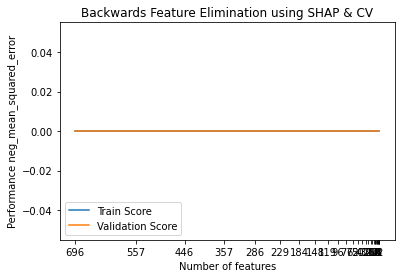

In [158]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=model_xgb, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(df_final[COLS], np.log1p(df_final['y']))

# Make plots
performance_plot = shap_elimination.plot()

In [ ]:
report

In [159]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=77)

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [160]:
final_features_set

['04_fr_para61',
 '18_hv_para3',
 '04_date_cos',
 '13_time_para62',
 '13_pressure_para91',
 '12_gas_para36',
 '17_time_para5',
 '12_time_para16',
 '04_position_para72',
 '06_temp_para65',
 '20_time_para83',
 '06_time_para44',
 '12_temp_para11',
 '12_weekday_cos',
 '13_time_para9',
 '04_time_para77',
 '13_tmp_para31',
 '13_time_para37',
 '17_time_para77',
 '13_time_para77',
 '12_temp_para23',
 '18_time_para5',
 '18_time_para83',
 '06_time_para9',
 '20_temp_para55',
 '17_time_para41',
 '13_gas_para73',
 '20_he_para88',
 '18_efem_para25',
 '17_tmp_para31',
 '12_time_para9',
 '20_time_para9',
 '04_temp_para65',
 '12_gas_para50',
 '17_time_para29',
 '18_time_para77',
 '20_temp_para65',
 '20_temp_para93',
 '04_temp_para18',
 '18_time_para42',
 '20_time_para37',
 '12_temp_para87',
 '06_gas_para73',
 '06_gas_para21',
 '12_time_para44',
 '17_he_para88',
 '12_time_para89',
 '17_time_para83',
 '06_power_para76',
 '06_power_para57',
 '12_fr_para28',
 '06_gas_para33',
 '04_temp_para55',
 '13_time_p

# 예측 결과 제출

In [ ]:
df_predict.head()

In [ ]:
pred_X = pd.get_dummies(df_predict[COLS])

In [ ]:
predict['msure_val'] = np.exp(cat.predict(df_predict_final[COLS]))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

In [ ]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

In [ ]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_12.csv')

# module 별 LeaveOneOut으로 모델링해보기

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [ ]:
train_idxs = list(df_final.groupby('module_name')['key_val'].nunique().values)
predict_idxs = list(df_predict_final.groupby('module_name')['key_val'].nunique().values)

In [ ]:
cv = LeaveOneOut()
cats = [CatBoostRegressor() for i in range(47)]
for i in range(len(idx)):
    if i==0:
        train_idx = range(idx[i])
    else:
        train_idx = range(idx[i-1], idx[i])
    

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

In [ ]:
mean(scores)

# Optuna + CatRegressor

In [ ]:
cats = [CatBoostRegressor() for i in range(47)]
idexss = 0
for i,idx in enumerate(train_idxs):
    if i==0:
        train_idx = range(idx)
        idexss += idx
    else:
        train_idx = range(idexss, idexss+idx)
        idexss += idx
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 12),
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
    #       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'task_type':'GPU',
          'devices':'0:7',
          'iterations':100,
          'rsm':1
      }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        cv = LeaveOneOut()
        cat = cats[i]
        cat.set_params(**param)
        scores = cross_val_score(cat, X_cat, y_cat, scoring='neg_mean_squared_error',
                                 cv=cv)
        scores = np.sqrt(-scores)

        return np.mean(scores)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective_CAT, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    CAT = CatBoostRegressor(**study.best_params)
    CAT.fit(X, np.log1p(y),verbose=0)
    cats[i] = CAT
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
pred = []
idexss_pred = 0
for i, (idx,model) in enumerate(zip(predict_idxs, cats)):
    if i == 0:
        pred_idx = range(idx)
        idexss_pred += idx
    else:
        pred_idx = range(idexss_pred, idexss_pred+idx)
        idexss_pred += idx
    X_pred = df_predict_final.loc[pred_idx, num_features]
    CAT_pred = model.predict(X_pred)
    pred.extend(CAT_pred)

In [ ]:
predict['msure_val'] = np.exp(pred)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

In [ ]:
len(df_submission)

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_15.csv')

# Cat 기본모델과 LooCV

In [ ]:
base_cat_params = {'task_type':'GPU','devices':'0:7','iterations':100,'rsm':1}
cats = [CatBoostRegressor(random_state=1,**base_cat_params) for i in range(47)]
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    cv = LeaveOneOut()
    cat = cats[i]
    scores = cross_val_score(cat, X_cat, y_cat, scoring='neg_mean_squared_error',
                                cv=cv)
    scores = np.sqrt(-scores)
    print(np.mean(scores))
    
    cat.fit(X, np.log1p(y))
    cats[i] = CAT
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
cats = []
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 12),
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
    #       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'task_type':'GPU',
          'devices':'0:8',
          'iterations':50,
          'rsm':1
      }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        loo = LeaveOneOut()
        cat = CatBoostRegressor(**param)
        loo.get_n_splits(X_cat)
        rmsle = []
        for train_idx, test_idx in loo.split(X_cat):
            cat.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:],y_cat.iloc[test_idx])], early_stopping_rounds=15, silent=True)
            cat_pred = cat.predict(X_cat.iloc[test_idx,:])
            rmsle_val = np.sqrt(mean_squared_error(y_cat.iloc[test_idx], cat_pred))
            rmsle.append(rmsle_val)
        return np.mean(rmsle)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective_CAT, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    loo = LeaveOneOut()
    CAT = CatBoostRegressor(**study.best_params)
    for train_idx, test_idx in loo.split(X_cat):
            CAT.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:], y_cat.iloc[test_idx])], early_stopping_rounds=15)
    cats.append(CAT)
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
import lightgbm as lgb

In [ ]:
cats = []
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective(trial):
        lgbm_param = {
            'objective': 'regression',
            'verbose': -1,
            'metric': 'rmsle', 
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
            'max_depth': trial.suggest_int('max_depth',3, 15),
            'learning_rate': trial.suggest_uniform("learning_rate", 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
            'random_state':0
        }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        loo = LeaveOneOut()
        cat = lgb.LGBMRegressor(**lgbm_param)
        loo.get_n_splits(X_cat)
        rmsle = []
        for train_idx, test_idx in loo.split(X_cat):
            cat.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:],y_cat.iloc[test_idx])], early_stopping_rounds=15, eval_metric='rmse')
            cat_pred = cat.predict(X_cat.iloc[test_idx,:])
            rmsle_val = np.sqrt(mean_squared_error(y_cat.iloc[test_idx], cat_pred))
            rmsle.append(rmsle_val)
        return np.mean(rmsle)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="lgb_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    loo = LeaveOneOut()
    CAT =  lgb.LGBMRegressor(**study.best_params)
    for train_idx, test_idx in loo.split(X_cat):
            CAT.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:], y_cat.iloc[test_idx])], early_stopping_rounds=15, eval_metric='rmse')
    cats.append(CAT)
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))